# Feature Space Grouping

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from zotbin.group import *
from zotbin.binned import get_zedges_chi

In [4]:
#from tomo_challenge import load_data, load_redshift

Load the Buzzard riz training data:

In [5]:
#bands='riz'
#include_colors=False
#include_errors=False

In [6]:
#train_file='/media/data2/tomo_challenge_data/ugrizy_buzzard/training.hdf5'
#train_data = load_data(train_file, bands, 
#                       errors=include_errors,
#                       colors=include_colors, array=True)
#train_z = load_redshift(train_file)
#print(f'Loaded {len(train_data)} training rows.')

In [6]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

In [7]:
def prepare_features(data, colors=True, pca=True, preprocessor=None):
    features = data
    if colors:
        # Add colors to the raw magnitudes.
        features = np.concatenate((features, np.diff(data, axis=1)), axis=1)
    if pca:
        print('Initializing PCA')
        pca = PCA(n_components=data.shape[1]).fit(features)
        print('Adding PCA')
        principal = pca.transform(features)
        features = np.concatenate((features, principal), axis=1)
    if preprocessor is None:
        print('Initializing preprocessor')
        preprocessor = RobustScaler()
        preprocessor.fit(features)
    return preprocessor.transform(features), preprocessor

In [7]:
#train_features, preproc = prepare_features(train_data)

Use i-r, z-i and i as the input features:

In [6]:
def prepare2(band='i', nmax=None, shuffle=False, seed=123):
    n = min(nmax or len(train_data), len(train_data))
    colors = np.diff(train_data, axis=1)
    i = bands.index(band)
    if shuffle:
        gen = np.random.RandomState(seed)
        idx = gen.choice(len(train_data), n, replace=False)
    else:
        idx = slice(None)
    return np.concatenate((colors[idx], train_data[idx, i:i + 1]), axis=1), train_z[idx]

In [8]:
#X, z = prepare()

In [9]:
#X = train_features[:, [5,6,7]]
#z = train_z

In [3]:
with np.load('uniform_buz_riz.npz') as keys:
    X = keys['uniform']
    z = keys['redshift']
print(f'Loaded {len(X)} training samples with ~uniform distribution.')

Loaded 5359494 training samples with ~uniform distribution.


Specify hyperparameters:

In [4]:
npct = 10
nzbin = 40
ngrp_save = (400,200,100)

Calculate redshift bins equally spaced in comoving distance:

In [6]:
zedges = get_zedges_chi(z, nzbin=nzbin)

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


Plot the feature space rectangular grid:

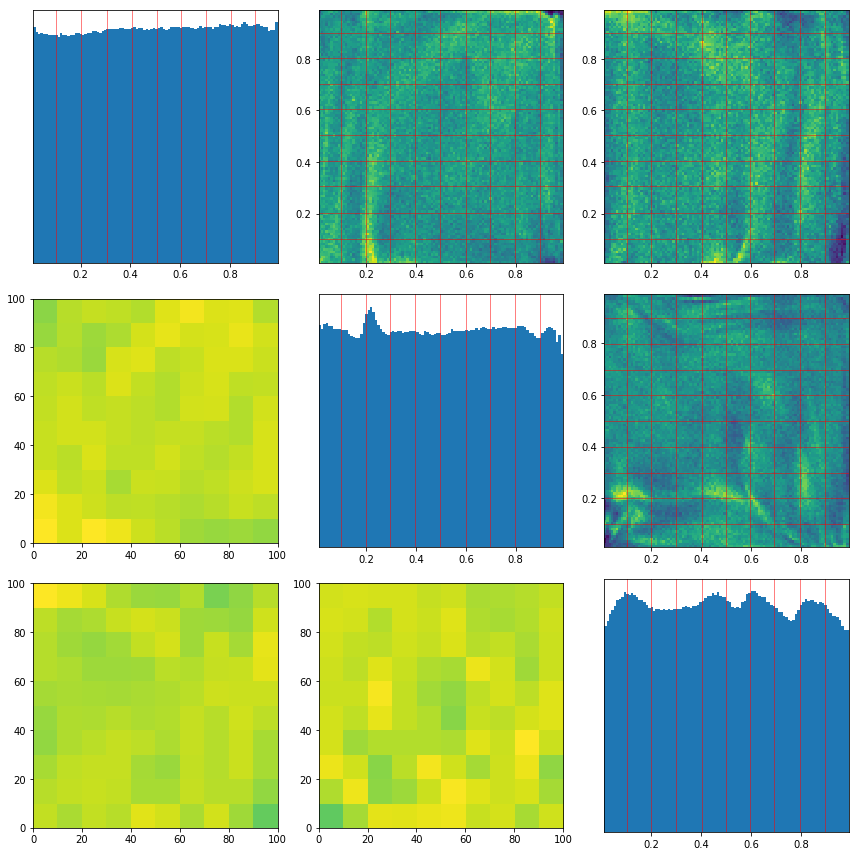

In [13]:
plotfbins(X, npct)

Plot the  corresponding redshift vectors:

In [15]:
def plotzvecs(features, redshift, zedges, npct=20, pnorm=2, sort=True):

    _, _, zhist = groupinit(features, redshift, zedges, npct)
    nfbin, nzbin = zhist.shape

    zhist = zhist.astype(float)
    iz = np.arange(nzbin)
    zmean = np.sum(iz * zhist, axis=1) / np.sum(zhist, axis=1)
    order = np.argsort(zmean)
    znorm = np.sum(zhist ** pnorm, axis=1, keepdims=True) ** (1 / pnorm)
    zhist = np.divide(zhist, znorm, where=znorm > 0, out=zhist)

    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.axis('off')
    ax.imshow(zhist[order], aspect='auto', origin='lower')
    plt.tight_layout()

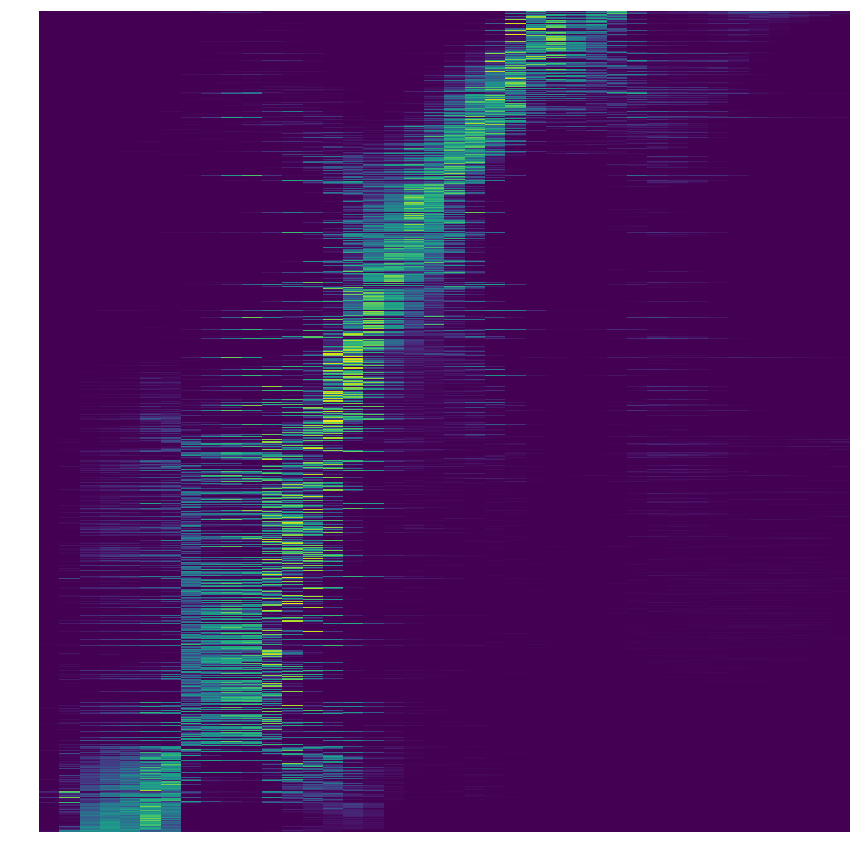

In [16]:
plotzvecs(X, z, zedges, npct)

Calculate feature-space groups with a weighted redshift similarity measure:

In [7]:
groupbins(X, z, zedges, npct, ngrp_save=ngrp_save, validate=True)

Grouping with ndata=5359494, nmin=26797, nmax=107190, nzbin=40, nfbin=1000.
Reduced to 900 groups after 100 iterations.
Reduced to 816 groups after 200 iterations.
Reduced to 723 groups after 300 iterations.
Reduced to 636 groups after 400 iterations.
Reduced to 551 groups after 500 iterations.
Reduced to 474 groups after 600 iterations.
Reduced to 402 groups after 700 iterations.
Finalizing result with 400 groups...
Validating saved results...
Saved 400 groups to group_400.npz
Reduced to 333 groups after 800 iterations.
Reduced to 273 groups after 900 iterations.
validating similarity matrices after 1000 iterations
Reduced to 211 groups after 1000 iterations.
Finalizing result with 200 groups...
Validating saved results...
Saved 200 groups to group_200.npz
Reduced to 146 groups after 1100 iterations.
Finalizing result with 100 groups...
Validating saved results...
Saved 100 groups to group_100.npz
Reached min_groups=100 after 1199 iterations.


In [8]:
groupbins(X, z, zedges, npct, ngrp_save=(100,), savename='group2_{N}.npz')

Grouping with ndata=5359494, nmin=26797, nmax=107190, nzbin=40, nfbin=1000.
Reduced to 900 groups after 100 iterations.
Reduced to 816 groups after 200 iterations.
Reduced to 723 groups after 300 iterations.
Reduced to 636 groups after 400 iterations.
Reduced to 551 groups after 500 iterations.
Reduced to 474 groups after 600 iterations.
Reduced to 402 groups after 700 iterations.
Reduced to 333 groups after 800 iterations.
Reduced to 273 groups after 900 iterations.
Reduced to 211 groups after 1000 iterations.
Reduced to 146 groups after 1100 iterations.
Finalizing result with 100 groups...
Saved 100 groups to group2_100.npz
Reached min_groups=100 after 1199 iterations.


In [8]:
def check_equal(fname1='group_100.npz', fname2='group2_100.npz'):
    load1 = load_groups(fname1)
    load2 = load_groups(fname2)
    for x1, x2 in zip(load1, load2):
        assert np.array_equal(x1, x2)
        
check_equal()

In [9]:
!ls -lh group_*.npz

-rw-rw-r-- 1 dkirkby dkirkby 119K Sep  9 07:18 group_100.npz
-rw-rw-r-- 1 dkirkby dkirkby 385K Sep  9 07:18 group_200.npz
-rw-rw-r-- 1 dkirkby dkirkby 1.4M Sep  9 07:18 group_400.npz


In [10]:
%time fedges, grpid, zhist, zsim = groupbins(X, z, zedges, npct, min_groups=ngrp, weighted=True)

Grouping with ndata=5410171, nmin=27051, nmax=108203, nzbin=120, nfbin=8000.
Reduced to 6936 groups after 100 iterations.
Reduced to 6836 groups after 200 iterations.
Reduced to 6736 groups after 300 iterations.
Reduced to 6636 groups after 400 iterations.
Reduced to 6536 groups after 500 iterations.
Reduced to 6436 groups after 600 iterations.
Reduced to 6433 groups after 700 iterations.
Reduced to 6433 groups after 800 iterations.
Reduced to 6398 groups after 900 iterations.
Reduced to 6300 groups after 1000 iterations.
Reduced to 6200 groups after 1100 iterations.
Reduced to 6100 groups after 1200 iterations.
Reduced to 6000 groups after 1300 iterations.
Reduced to 5900 groups after 1400 iterations.
Reduced to 5807 groups after 1500 iterations.
Reduced to 5707 groups after 1600 iterations.
Reduced to 5626 groups after 1700 iterations.
Reduced to 5626 groups after 1800 iterations.
Reduced to 5626 groups after 1900 iterations.
Reduced to 5614 groups after 2000 iterations.
Reduced to 5

In [12]:
%time fedges, grpid, zhist, zsim = groupbins(X, z, zedges, npct, min_groups=ngrp, weighted=True)

Grouping with ndata=5410171, nmin=27051, nmax=108203, nzbin=120, nfbin=8000.
Reduced to 6936 groups after 100 iterations.
Reduced to 6836 groups after 200 iterations.
Reduced to 6736 groups after 300 iterations.
Reduced to 6636 groups after 400 iterations.
Reduced to 6536 groups after 500 iterations.
Reduced to 6436 groups after 600 iterations.
Reduced to 6433 groups after 700 iterations.
Reduced to 6433 groups after 800 iterations.
Reduced to 6398 groups after 900 iterations.
Reduced to 6300 groups after 1000 iterations.
Reduced to 6200 groups after 1100 iterations.
Reduced to 6100 groups after 1200 iterations.
Reduced to 6000 groups after 1300 iterations.
Reduced to 5900 groups after 1400 iterations.
Reduced to 5807 groups after 1500 iterations.
Reduced to 5707 groups after 1600 iterations.
Reduced to 5626 groups after 1700 iterations.
Reduced to 5626 groups after 1800 iterations.
Reduced to 5626 groups after 1900 iterations.
Reduced to 5614 groups after 2000 iterations.
Reduced to 5

Calculate feature-space groups with an un-weighted redshift similarity measure:

In [13]:
%time fedges2, grpid2, zhist2, zsim2 = groupbins(X, z, zedges, npct, min_groups=ngrp, weighted=False)

Grouping with ndata=5410171, nmin=27051, nmax=108203, nzbin=120, nfbin=8000.
Reduced to 6936 groups after 100 iterations.
Reduced to 6836 groups after 200 iterations.
Reduced to 6736 groups after 300 iterations.
Reduced to 6636 groups after 400 iterations.
Reduced to 6536 groups after 500 iterations.
Reduced to 6436 groups after 600 iterations.
Reduced to 6336 groups after 700 iterations.
Reduced to 6236 groups after 800 iterations.
Reduced to 6136 groups after 900 iterations.
Reduced to 6036 groups after 1000 iterations.
Reduced to 5936 groups after 1100 iterations.
Reduced to 5836 groups after 1200 iterations.
Reduced to 5736 groups after 1300 iterations.
Reduced to 5636 groups after 1400 iterations.
Reduced to 5536 groups after 1500 iterations.
Reduced to 5436 groups after 1600 iterations.
Reduced to 5336 groups after 1700 iterations.
Reduced to 5236 groups after 1800 iterations.
Reduced to 5136 groups after 1900 iterations.
Reduced to 5036 groups after 2000 iterations.
Reduced to 4

Save the results:

In [11]:
save_groups(f'groups_{npct}_{nzbin}_{ngrp}.npz', zedges, fedges, grpid, zhist, zsim)

In [16]:
save_groups(f'groups_{npct}_{nzbin}_{ngrp}.npz', zedges, fedges, grpid, zhist, zsim)
save_groups(f'groups_{npct}_{nzbin}_{ngrp}_nowgt.npz', zedges, fedges2, grpid2, zhist2, zsim2)
!ls -lh groups*.npz

-rw-rw-r-- 1 dkirkby dkirkby 534K Aug 31 16:13 groups_16_120_200_nowgt.npz
-rw-rw-r-- 1 dkirkby dkirkby 534K Aug 31 16:13 groups_16_120_200.npz
-rw-rw-r-- 1 dkirkby dkirkby 566K Aug 31 19:27 groups_20_120_200_nowgt.npz
-rw-rw-r-- 1 dkirkby dkirkby 566K Aug 31 19:27 groups_20_120_200.npz


Plot the redshift distributions in the output groups (sorted by mean z):

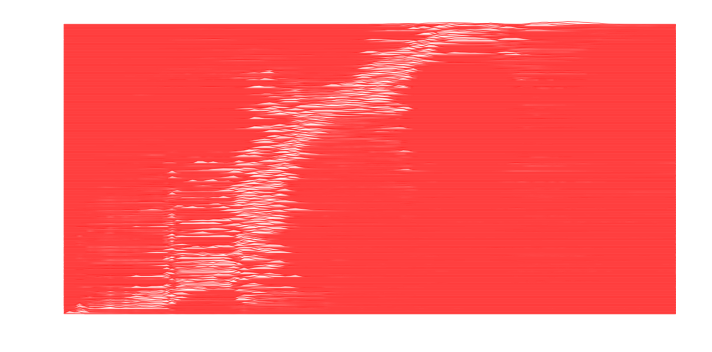

In [12]:
plotzgrp(zhist)

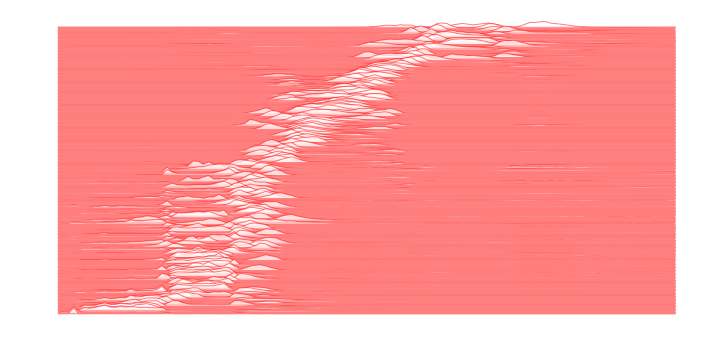

In [17]:
plotzgrp(zhist)

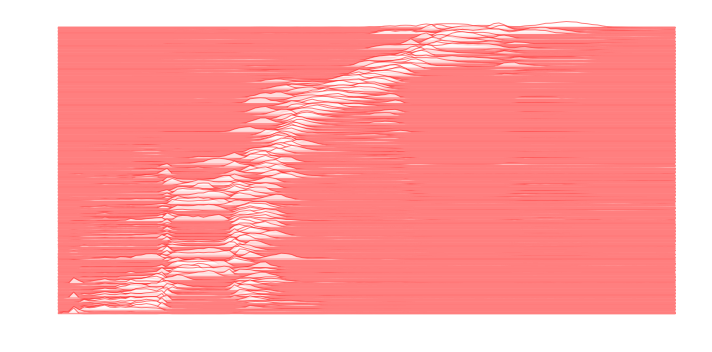

In [23]:
plotzgrp(zhist)

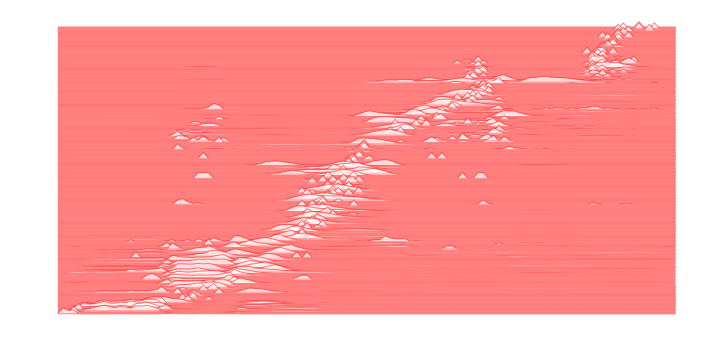

In [18]:
plotzgrp(zhist2)

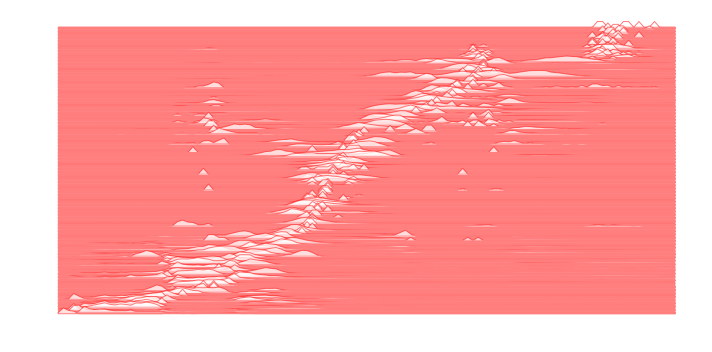

In [24]:
plotzgrp(zhist2)

Do a small test with validation turned on:

In [20]:
groupbins(X[:10000], z[:10000], zedges, npct=10, min_groups=ngrp, weighted=True, validate=True);

Grouping with ndata=10000, nmin=50, nmax=200, nzbin=120, nfbin=1000.
Reduced to 764 groups after 100 iterations.
Reduced to 706 groups after 200 iterations.
Reduced to 676 groups after 300 iterations.
Reduced to 635 groups after 400 iterations.
Reduced to 593 groups after 500 iterations.
Reduced to 546 groups after 600 iterations.
Reduced to 498 groups after 700 iterations.
Reduced to 466 groups after 800 iterations.
Reduced to 435 groups after 900 iterations.
validating similarity matrices after 1000 iterations
Reduced to 389 groups after 1000 iterations.
Reduced to 346 groups after 1100 iterations.
Reduced to 309 groups after 1200 iterations.
Reduced to 273 groups after 1300 iterations.
Reduced to 223 groups after 1400 iterations.
Reached min_groups=200 after 1457 iterations.
Validating final results


Embed groups into a periodic 1D latent space, along the lines of tSNE. This doesn't seem to be useful, perhaps due some bugs.

In [25]:
import jax
import jax.numpy as jnp

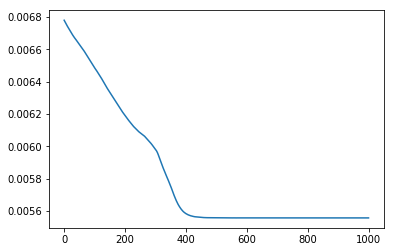

In [26]:
def embed(zsim, nstep=100, eta=0.01, alpha=1, seed=123):
    
    ngrp = len(zsim)
    
    # Initialize random latent space coordinates.
    gen = np.random.RandomState(seed)
    phi = jnp.array(gen.uniform(size=ngrp))
    offdiag = jnp.where(jnp.identity(ngrp) == 0)

    # Normalize the similarity matrix to obtain feature-space probabilities.
    p = jnp.array(zsim / zsim.sum(axis=1, keepdims=True)) ** alpha
    p /= p[offdiag].sum()
    assert jnp.all(p[offdiag] > 0)
    
    # Define a KL loss function.
    @jax.jit
    def KL(phi):
        # Calculate the latent space distance matrix with periodic boundary conditions.
        phi2 = phi.reshape(-1, 1)
        dphisq = (phi2 - phi) ** 2 + 1 - 2 * jnp.maximum(jnp.abs(phi2 - phi), 0.5)
        # Calculate student-t probabilities.
        q = 1 / (1 + dphisq)        
        q /= q[offdiag].sum()
        # Calculate KL(p || q)
        return jnp.sum(p[offdiag] * jnp.log(p[offdiag] / q[offdiag]))
    
    KL_value_grad = jax.jit(jax.value_and_grad(KL))
    
    losses = []
    for i in range(nstep):
        loss, grads = KL_value_grad(phi)
        phi -= eta * grads
        losses.append(float(loss))
        #print(i, losses[-1])
    plt.plot(losses)
    return phi

phi = embed(zsim, eta=10., nstep=1000, seed=1)

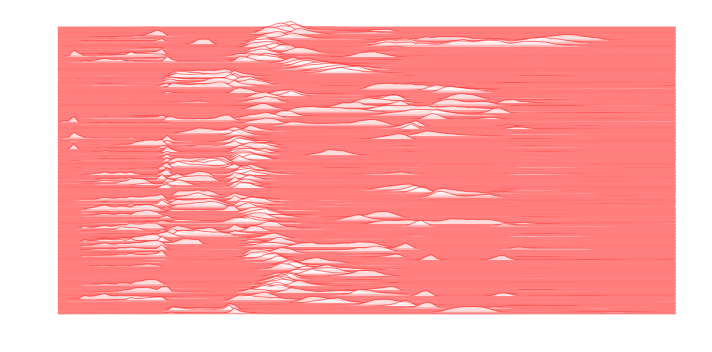

In [29]:
plotzgrp(zhist[np.argsort(phi)], sort=False)

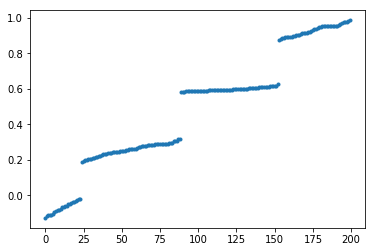

In [31]:
plt.plot(phi[np.argsort(phi)], '.');

## Sandbox

Build a binary tree partition of the feature space:

In [234]:
def get_leaves(node):
    if node.left is None and node.right is None:
        return [node]
    else:
        return get_leaves(node.left) + get_leaves(node.right)

In [260]:
def get_tree_zhist(tree):
    # Loop over leaf nodes.
    leaves = get_leaves(tree)
    nleaves = len(leaves)
    nz = len(tree.zhist)
    zhist = np.empty((nleaves, nz), int)
    for i, leaf in enumerate(leaves):
        zhist[i] = leaf.zhist
    iz = np.arange(nz)
    zmean = np.sum(iz * zhist, axis=1) / np.sum(zhist, axis=1)
    isort = np.argsort(zmean)
    return zhist[isort], [leaves[i] for i in isort]

In [261]:
zhist, leaves = get_tree_zhist(tree)

In [277]:
zhist2, leaves2 = get_tree_zhist(tree2)

In [273]:
def compress_zhist(zhist, maxfrac=1e-3, maxfull=1):
    nhist, nzbin = zhist.shape
    assert nzbin <= 64
    one = np.uint64(1)
    full = one * (zhist > maxfrac * zhist.sum(axis=1, keepdims=True))
    nfull = np.sum(full, axis=1)
    signature = np.sum(full * (one << np.arange(nzbin, dtype=np.uint64)), axis=1)
    merged = {}
    grpid = []
    zhist_out = []
    for i, sig in enumerate(signature):
        if sig in merged:
            zhist_out[merged[sig]] += zhist[i]
            grpid.append(merged[sig])
        else:
            zhist_out.append(zhist[i])
            grpid.append(i)
            if nfull[i] <= maxfull:
                merged[sig] = len(zhist_out) - 1
    print(f'Compressed {nhist} down to {len(zhist_out)}')
    return np.array(zhist_out), np.array(grpid)

In [272]:
zhist_out, grpid = compress_zhist(zhist)

Compressed 2066 down to 2033


In [279]:
zhist_out2, grpid2 = compress_zhist(zhist2, maxfrac=0.001)

Compressed 830 down to 830


In [282]:
np.savez('tree.npz', zedges=zedges, zhist=zhist_out2, grpid=grpid2)

In [283]:
!ls -lh tree.npz

-rw-rw-r-- 1 dkirkby dkirkby 267K Sep  4 16:36 tree.npz


In [227]:
def plotzgrp(zhist, zedges=None, stretch=4, sort=False, figsize=(10,5)):
    ngrp, nzbin = zhist.shape
    if zedges is None:
        zc = np.arange(nzbin)
    else:
        zc = 0.5 * (zedges[1:] + zedges[:-1])
    zplot = zhist / zhist.max(axis=1, keepdims=True)
    if sort:
        zavg = np.sum(zhist * np.arange(nzbin), axis=1) / np.sum(zhist, axis=1)
        zplot = zplot[np.argsort(zavg)]
    fig = plt.figure(figsize=figsize)
    yoffsets = np.arange(ngrp) / stretch
    for dndz, dy in zip(zplot[::-1], yoffsets[::-1]):
        #plt.plot(zc, dndz + dy, 'r-', alpha=0.5)
        plt.fill_between(zc, dndz + dy, dy, facecolor=(1, 1, 1, 0.75), edgecolor=(1, 0, 0, 0.5), lw=1)
    plt.gca().axis('off')
    plt.tight_layout()

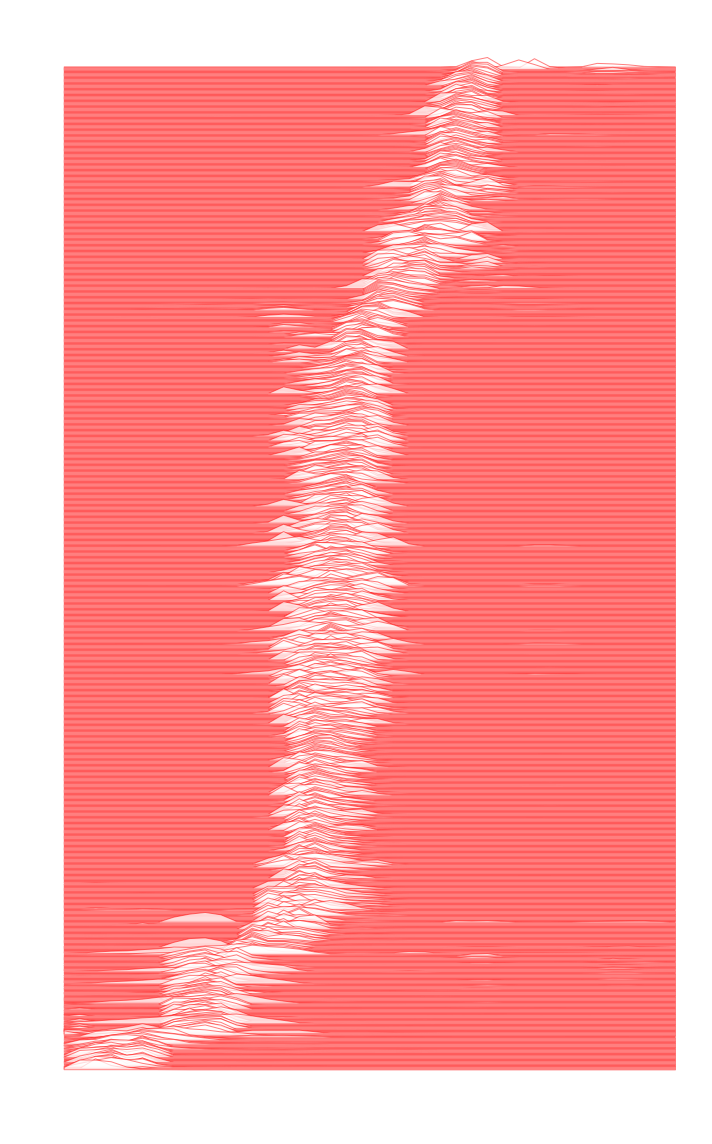

In [270]:
plotzgrp(zhist_out2, sort=True, figsize=(10, 16), stretch=8)

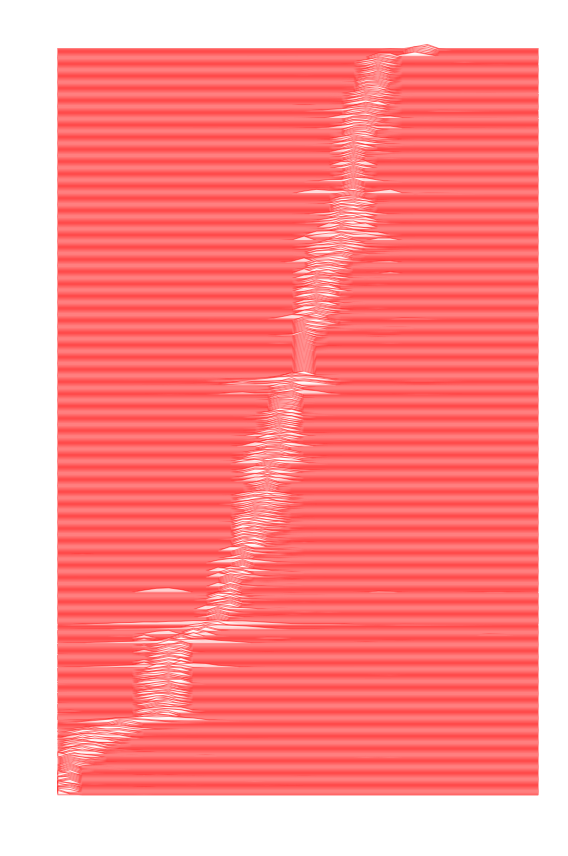

In [202]:
plotzgrp(zhist, sort=False, figsize=(8, 12))

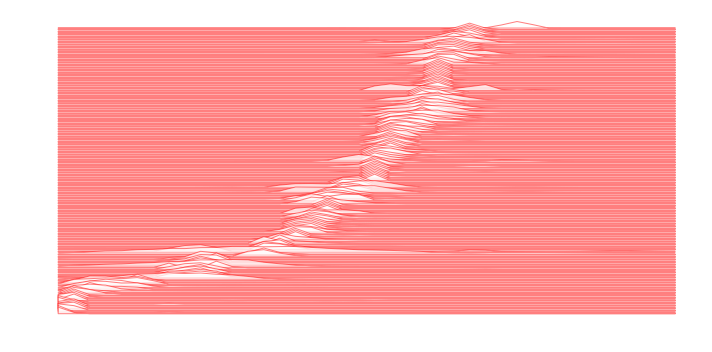

In [186]:
plotzgrp(zhist, sort=True)

In [266]:
%time tree2 = Tree(train_features, train_z, zedges, maxfull=1, maxdepth=32, minsamples=10000)

(0, 0, 1, 1, 0)
(0, 0, 1, 1, 1)
(1, 0, 1, 1, 0)
(1, 0, 1, 1, 1)
(1, 1, 0, 0, 0)
(1, 1, 0, 0, 1)
(1, 1, 0, 1, 0)
(1, 1, 0, 1, 1)
(1, 1, 1, 0, 0)
(1, 1, 1, 0, 1)
(1, 1, 1, 1, 0)
(1, 1, 1, 1, 1)
CPU times: user 6min 19s, sys: 3.26 s, total: 6min 22s
Wall time: 6min 22s


In [250]:
%time tree = Tree(train_features, train_z, zedges, maxfull=1, maxdepth=24, minsamples=1000)

(0, 0, 0, 1, 0)
(0, 0, 0, 1, 1)
(0, 0, 1, 0, 0)
(0, 0, 1, 0, 1)
(0, 0, 1, 1, 0)
(0, 0, 1, 1, 1)
(0, 1, 1, 0, 0)
(0, 1, 1, 0, 1)
(1, 0, 0, 1, 0)
(1, 0, 0, 1, 1)
(1, 0, 1, 0, 0)
(1, 0, 1, 0, 1)
(1, 0, 1, 1, 0)
(1, 0, 1, 1, 1)
(1, 1, 0, 0, 0)
(1, 1, 0, 0, 1)
(1, 1, 0, 1, 0)
(1, 1, 0, 1, 1)
(1, 1, 1, 0, 0)
(1, 1, 1, 0, 1)
(1, 1, 1, 1, 0)
(1, 1, 1, 1, 1)
CPU times: user 5min 36s, sys: 5.89 s, total: 5min 42s
Wall time: 5min 42s


In [249]:
class Tree:
    def __init__(self, X_node, z_node, zedges, nsplit=50, maxfrac=1e-3, maxfull=4, minsamples=1000, maxdepth=12, path=[], plot=False):
        self.path = tuple(path)
        depth = len(self.path)
        self.zhist, _ = np.histogram(z_node, zedges)
        self.nfull = np.count_nonzero(self.zhist >= maxfrac * self.zhist.sum())
        self.axis, self.split, self.score, sel = best_node_split(X_node, z_node, zedges)
        if plot:
            zc = 0.5 * (zedges[1:] + zedges[:-1])
            plt.plot(zc, self.zhist, 'o')
            plt.hist(z_node[sel], zedges, histtype='step')
            plt.hist(z_node[~sel], zedges, histtype='step')
            plt.show()
        if depth < maxdepth and self.nfull > maxfull and len(X_node) >= minsamples and sel is not None:
            #print('split node:', self.path, self.nfull, len(X_node), self.axis, self.split, self.score)
            self.left = Tree(X_node[sel], z_node[sel], zedges, nsplit, maxfrac, maxfull, minsamples, maxdepth, path=self.path + (0,))
            self.right = Tree(X_node[~sel], z_node[~sel], zedges, nsplit, maxfrac, maxfull, minsamples, maxdepth, path=self.path + (1,))
        else:
            #print('leaf node:', self.nfull, len(self.path), len(X_node), self.path)
            self.left = self.right = None
        if depth == 5:
            print(self.path)

In [161]:
def best_node_split(X_node, z_node, zedges, nsplit=50, maxfrac=1e-4):
    max_score = -1
    best_axis, best_split, best_sel = None, None, None
    for axis, X_axis in enumerate(X_node.T):
        split, score, sel = best_axis_split(X_axis, z_node, zedges, nsplit, maxfrac)
        if score is not None and score > max_score:
            max_score = score
            best_axis = axis
            best_split = split
            best_sel = sel
    return best_axis, best_split, max_score, best_sel

In [167]:
def best_axis_split(X_axis, z_node, zedges, nsplit=50, maxfrac=1e-4):
    # Subdivide this axis.
    splits = np.percentile(X_axis, np.linspace(0, 100, nsplit + 2))
    if not np.all(np.diff(splits) > 0):
        return None, None, None
    splits[-1] += 1
    # Assign each sample to a subdivision.
    idx = np.digitize(X_axis, splits) - 1
    assert np.all((idx >= 0) & (idx < nsplit + 1))
    # Histogram redshift in each subdivision.
    zhist = np.array([np.histogram(z_node[idx == i], zedges)[0] for i in range(nsplit + 1)])
    # Find the best split.
    score = split_scores(zhist, maxfrac)
    ibest = np.argmax(score)
    best_split = splits[1 + ibest]
    max_score = score[ibest]
    sample_sel = idx <= ibest
    return best_split, max_score, sample_sel

In [145]:
def split_scores(zhist, maxfrac):
    # Build cummulative histograms for each possible split.
    zhist_lo = np.cumsum(zhist, axis=0)
    zhist_hi = zhist_lo[-1] - zhist_lo
    # Identify (almost) empty bins in the cummulative histograms below and above each cut.
    empty_lo = zhist_lo[:-1] <= maxfrac * zhist_lo[:-1].sum(axis=1, keepdims=True)
    empty_hi = zhist_hi[:-1] <= maxfrac * zhist_hi[:-1].sum(axis=1, keepdims=True)
    # Calculate the score for each possible split.
    return np.count_nonzero(empty_lo, axis=1) + np.count_nonzero(empty_hi, axis=1) + np.count_nonzero(empty_lo | empty_hi, axis=1)

[ 9 12  9  9  8  7  6  8 15 18]


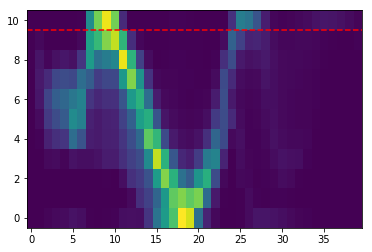

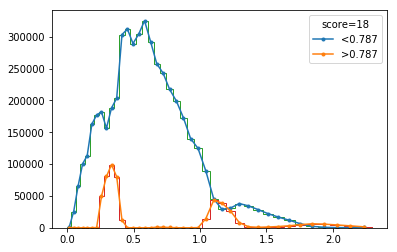

In [80]:
best_axis_split(train_features[:, 7], z, zedges, nsplit=10, maxfrac=5e-4, plot=True);

Load optimal binnings with nbin=2,4,8:

In [10]:
label2 = np.load('buzzard_labels2.npy')
label4 = np.load('buzzard_labels4.npy')
label8 = np.load('buzzard_labels8.npy')

In [17]:
def plot_scatter(X, labels=label2, clip_pct=0):
    
    labels = labels[:len(X)]

    # Calculate plot limits.
    limits = np.percentile(X, (clip_pct, 100 - clip_pct), axis=0).T
    
    fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12,12))
    axes = axes.flat

    nlabel = labels.max() + 1
    for i in range(nlabel):
        ax = axes[i]
        sel = labels == i
        S = ax.scatter(X[sel, 0], X[sel, 1], lw=0, s=5, c=X[sel, 2], vmin=limits[2,0], vmax=limits[2,1])
        ax.set_xlim(*limits[0])
        ax.set_ylim(*limits[1])
        plt.colorbar(S, ax=ax)
        
    ax = axes[-1]
    S = ax.scatter(X[:, 0], X[:, 1], lw=0, s=5, c=0.1 * labels + 0.05, cmap='tab10', vmin=0, vmax=1)
    ax.set_xlim(*limits[0])
    ax.set_ylim(*limits[1])
    plt.colorbar(S, ax=ax)

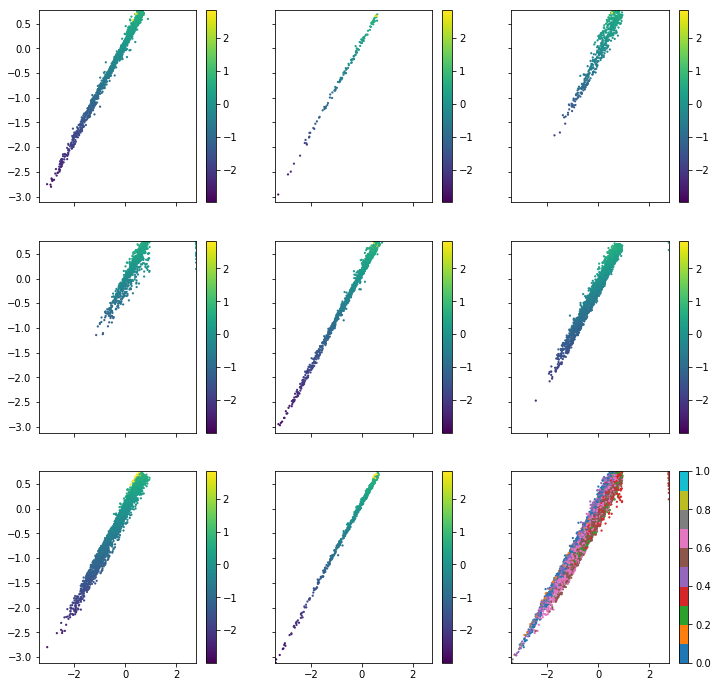

In [18]:
plot_scatter(train_features[:10000,[0,1,2]], labels=label8, clip_pct=0.1)

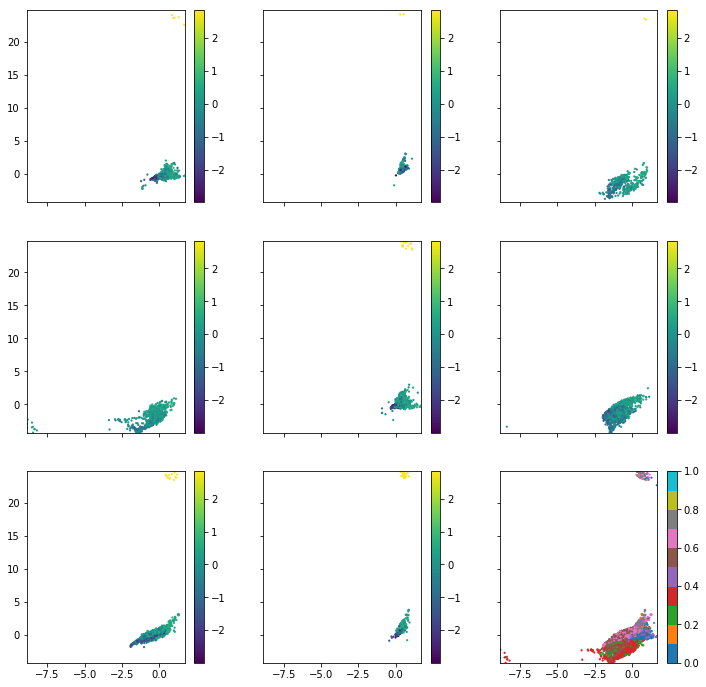

In [19]:
plot_scatter(train_features[:10000,[3,4,2]], labels=label8, clip_pct=0.1)

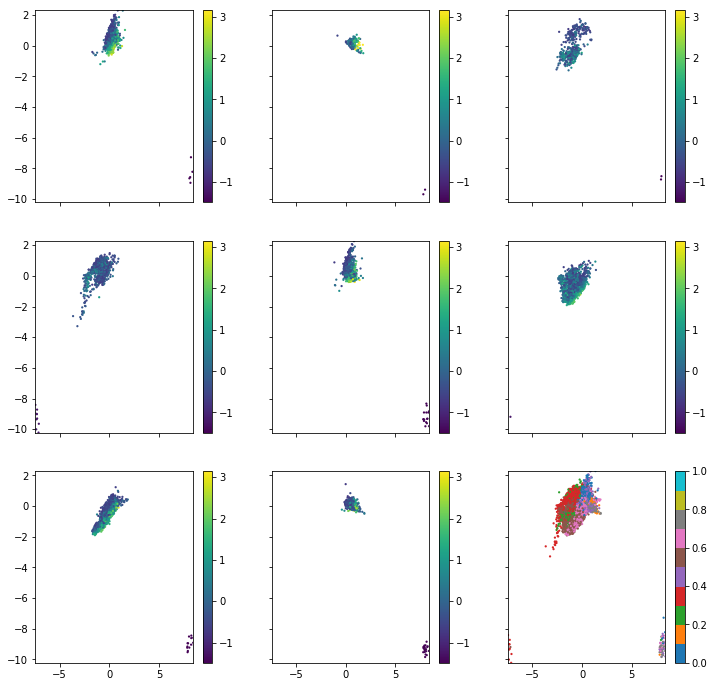

In [21]:
plot_scatter(train_features[:10000,[6,7,5]], labels=label8, clip_pct=0.1)

In [ ]:
init_data = load_binned('binned_40.npz')
zedges = init_data[0]

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
import sklearn
sklearn.__version__

'0.23.2'

In [12]:
RF = RandomForestClassifier(n_estimators=100, min_samples_split=0.01, oob_score=True, n_jobs=8, random_state=123, max_samples=0.1)

In [13]:
RF.fit(X, label8)

RandomForestClassifier(max_samples=0.1, min_samples_split=0.01, n_jobs=8,
                       oob_score=True, random_state=123)

In [14]:
RF.score(X, label8)

0.5496295773275928